In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
from datetime import datetime, timedelta

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

connection = engine.connect()

In [23]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with = engine)

# reflect the tables
Base.classes.keys()


['measurement', 'station']

In [24]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(classes)

['measurement', 'station']


In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

#Used [0] to remove the ',' at the end

'2017-08-23'

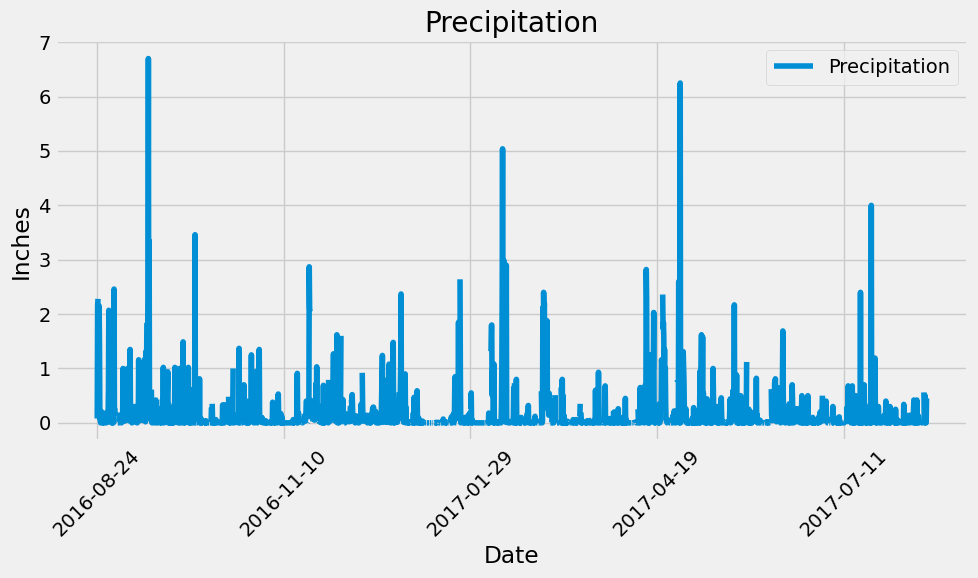

Earliest Date: 2016-08-23
Latest Date: 2017-08-23


In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

one_year_ago = most_recent_date - timedelta(days=365)

precipitation_data = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= one_year_ago) \
    .order_by(Measurement.date) \
    .all()

df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

df = df.sort_values(by='Date')

df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Earliest Date: {one_year_ago.strftime('%Y-%m-%d')}")
print(f"Latest Date: {most_recent_date.strftime('%Y-%m-%d')}")

In [ ]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_statistics = df['Precipitation'].describe()
summary_table = summary_statistics.to_frame()
summary_table = summary_table.rename(columns={'precipitation': 'Precipitation'})
summary_table.head(8)

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station,func.count(Measurement.station).label('count'))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
        .all()

[(53.0, 87.0, 73.09795396419437)]

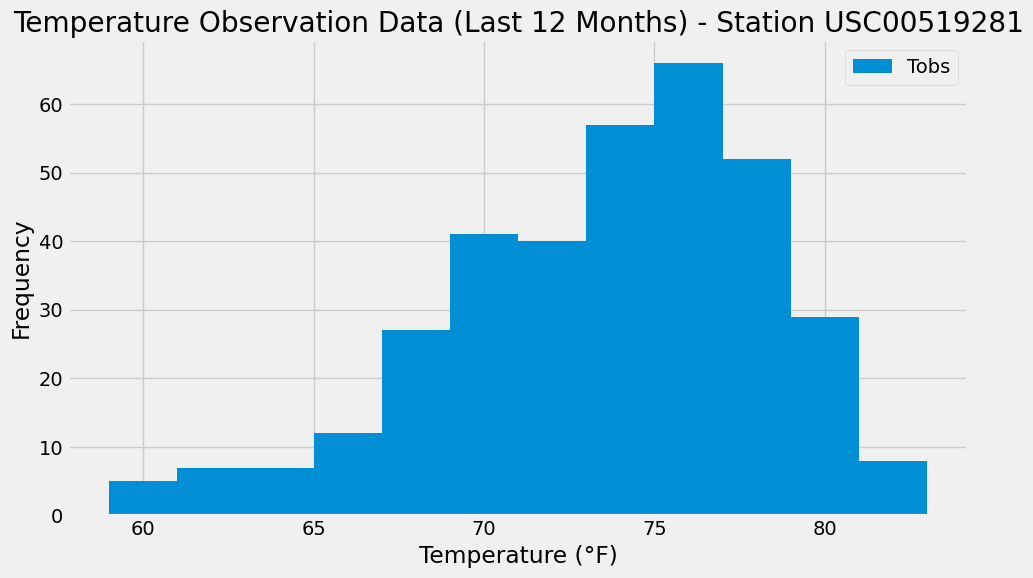

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the station with the most observations
most_active_station = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .first()[0]

# Find the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Query the previous 12 months of TOBS data for the most active station
tobs_data = session.query(Measurement.tobs) \
    .filter(Measurement.station == most_active_station) \
    .filter(Measurement.date >= one_year_ago) \
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column name
df = pd.DataFrame(tobs_data, columns=['Temperature'])

# Use Pandas Plotting with Matplotlib to plot the data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Temperature'], bins=12, label='Tobs')
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Temperature Observation Data (Last 12 Months) - Station {most_active_station}")
plt.tight_layout()
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()